# ***1) Ask - Defining the issue and what would equal a sucessfull result.***

###   1.1) The problem :

  ```The company you work for was hired by a real estate investing group that is looking to buy property in Lisbon. They want to get real estate data from the leading portal in Portugal, Idealista, to provide an overview of real estate prices in Lisbon.```

  ```After collecting the data, the investor asks us to perform a market analysis in specific Lisbon neighborhoods```

 ###  1.2) What would equal a sucessfull result :
  ```To fulfill the investors’ preferences: The investor is looking for apartments or duplex T0, T1 or T2, with a maximum price of 500.000€, a price per square meter below the sub-region average, above the ground floor (1st floor or higher).```

# ***2) Prepare - By collecting and storing information.***



### 2.1) Collecting method: 
```We will collect real-world data by building a web scrapper which will automatically extract the data available in the website that we can then manipulate and store in different formats such as PFD, excell or other formats ```

### Defining the regions requested by the stakeholder.

In [ ]:
lumiar = "https://www.idealista.pt/comprar-casas/lisboa/lumiar/pagina-1"
benfica = "https://www.idealista.pt/comprar-casas/lisboa/sao-domingos-de-benfica/pagina-1"
campolide = "https://www.idealista.pt/comprar-casas/lisboa/campolide/pagina-1"

### Building the web scrapper for one of the biggest real estate websites in Portugal : idealista.

In [ ]:
#importing necessary libraries
import requests
from bs4 import  BeautifulSoup
import html5lib
import re
from random import randint
from time import sleep
import pandas as pd

#arrays which will contain the data for each topic
precos = []
contactos = []
titulos = []
links = []
ids = []
typology = []
floors = []
area = []
regiao = []

#dictionaire containing all the containers above. We will later turn it into a DataFrame.
list_anuncios = {'id':ids,'titulo':titulos,'regiao':regiao, 'preco' : precos,'typology':typology,'area':area,'floor':floors, 'link':links, 'contacto' : contactos}

#funcao start scrape recebe o url da primeira pagina e faz o seguinte :
# 1) Cria a sopa com o conteudo da página e envia-a para a funcao soup_filter.
# 2) Procura pelo URL da página seguinte e chama-se a si própria com o URL da página seguinte.
def start_scrape(url):
    #make http request to the server:
    res = requests.get(url , headers={
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,'\
            'image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'pt-PT,pt;q=0.9,en-US;q=0.8,en;q=0.7',
        'cache-control': 'max-age=0',
        'referer': 'https://www.idealista.pt/en/comprar-casas/lisboa/?ordem=atualizado-desc',
        'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
        'sec-ch-ua-mobile': '?0',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) '\
            'Chrome/91.0.4472.77 Safari/537.36'
    })
    #Print server response and make sure we are authorized.
    print(f"Nova página solicitada.Server Response : {res}")
    #Make a soup with the content received from the server.
    sopa = BeautifulSoup(res.content, 'html5lib')
    soup_filter(sopa)
    #Search in the soup the element which contains the URL for the next page.
    paginacao = str(BeautifulSoup(res.content, 'html5lib').find_all('a', attrs ={'class':'icon-arrow-right-after'}))
    #If we do not find the element which contains the url, then exit the function.
    if paginacao == "[]":
      print("Não foram encontradas mais páginas..\nScraping concluído para esta região!")
      return 
    #create a REGEX pattern to extract the link from inside the HTML
    paginacao_regex = re.compile(r'href="(.+?)"')
    pagina_seguinte = str(re.findall(paginacao_regex, paginacao))
    #loop to replace undesired characters from the string
    for i in pagina_seguinte:
      if i == "[" or i == "]" or i == "'":
        pagina_seguinte = pagina_seguinte.replace(i , "")

    link_pagina_seguinte = 'http://idealista.pt' + pagina_seguinte
    #sleep a little before making the request again to the server, in order to not be blocked or overload the server.
    sleep(randint(2,4))
    
    start_scrape(link_pagina_seguinte)

#Let's extract the main ingredients from the soup.
def soup_filter(soup):
  soup_ingredients = soup.find_all('div', attrs={'class' : 'item-info-container'})
  regiao_do_imovel = soup.find_all('span', attrs={'class' : 'breadcrumb-title icon-arrow-dropdown-after'})


  z = 0
  for ingredient in soup_ingredients: 
    #price section - finding price in soup and extracting only the values from the html tags
    table_preco = str(soup_ingredients[z].find_all(name='span', attrs={"class":"item-price h2-simulated"}))
    preco_regex = re.compile(r'>(\d.+?)<')
    clean_price = str(re.findall(preco_regex, table_preco))
    #removing unwanted characters from the price
    for i in clean_price:
      if i == "[" or i == "]" or i == '.' or i == "'" or i == '"':
        clean_price = clean_price.replace(i,'').strip()
    if len(clean_price) > 0:
        precos.append(clean_price)
    else:
      #if there is no price in the extracted data we will fill it with a value of 000
        precos.append("000")
    
    #contact section
    table_contact = str(soup_ingredients[z].find_all(name='span', attrs={'class': 'icon-phone item-not-clickable-phone'}))
    contact_regex = re.compile(r'>(\d.+?)<')
    clean_contact = re.findall(contact_regex, table_contact)
    if len(clean_contact) > 0:
        contactos.append(clean_contact[0])
    else:
        contactos.append("000000000")

    #title section
    table_title = str(soup_ingredients[z].find_all(name='a', attrs={'role': 'heading'}))
    title_regex = re.compile(r'title=(\".+?\")')
    clean_title = str(re.findall(title_regex, table_title)).replace(",", "")
    #removing unwanted characters from the title
    for i in clean_title:
        if i == "[" or i == "]" or i == "'" or i == '"':
            clean_title = clean_title.replace(i, "").strip()
    if len(clean_title) > 0:
        titulos.append(clean_title)
    else:
        titulos.append("000")

    #link section
    table_link = str(soup_ingredients[z].find_all(name='a', attrs={'role': 'heading'}))
    link_regex = re.compile(r'href=(\".+?\")')
    clean_link = 'idealista.pt' + str(re.findall(link_regex, table_link))
    #removing unwanted characters from the link
    for i in clean_link:
        if i == "[" or i == "]" or i == "'" or i == '"':
            clean_link = clean_link.replace(i, "").strip()    
    if len(clean_link) > 0:
        links.append(clean_link)
    else:
      #if there is no link in the data , we will fill it with a value of 000
        links.append("000")

    #ID section - simply remove the numbers from the links
    table_id = clean_link
    id_regex = re.compile(r'/(\d+)/')
    clean_id = str(re.findall(id_regex, str(table_id)))
    #removing unwanted characters from the ID
    for i in clean_id:
        if i == "[" or i == "]" or i == "'":
            clean_id = clean_id.replace(i, "").strip()    
    if len(clean_id) > 0:
        ids.append(clean_id)
    else:
      #if there is no ID in the data , we will fill it with a value of 000
        ids.append("000")

    #regiao section
    regiao_do_imovel_regex = re.compile(r'>(\D+)<')
    regiao_descascada = str(re.findall(regiao_do_imovel_regex, str(regiao_do_imovel)))
    for i in regiao_descascada:
        if i == "[" or i == "]" or i == "'":
            regiao_descascada = regiao_descascada.replace(i, "").strip()
    regiao.append(regiao_descascada)

    #typology section
    table_typology = str(soup_ingredients[z].find_all(name='span', attrs={'class': 'item-detail'}))
    typology_regex = re.compile(r'>(T.+?)<')
    clean_typology = str(re.findall(typology_regex, table_typology))
    for i in clean_typology:
        if i == "[" or i == "]" or i == "'":
            clean_typology = clean_typology.replace(i, "").strip()
    if len(clean_typology) > 0:
        typology.append(clean_typology)
    else:
      #if there is no typology in the data , we will fill it with a value of 000
        typology.append("000")

    #floor section
    table_floor = str(soup_ingredients[z].find_all(name='span', attrs={'class': 'item-detail'}))
    floor_regex = re.compile(r'>([\d]{1,2}º andar.?)<')
    clean_floor = str(re.findall(floor_regex, table_floor))
    for i in clean_floor:
        if i == "[" or i == "]" or i == "'" or i == 'º' or i.isalpha() or i == ',':
            clean_floor = clean_floor.replace(i, "").strip()
    if len(clean_floor) > 0:
      floors.append(clean_floor)
    else:
      #if there is no floor in the data , we will fill it with a value of 9999
      floors.append('9999')

    #area section
    table_area = str(soup_ingredients[z].find_all(name='span', attrs={'class': 'item-detail'}))
    area_regex = re.compile(r'>(\d.+?)<')
    clean_area = str(re.findall(area_regex,table_area)).split(',')[0]
    for i in clean_area:
        if i == "[" or i == "]" or i == "'" or i == '.':
            clean_area = clean_area.replace(i, "").strip()
    if len(clean_area) > 0:
        area.append(clean_area)
    else:
      #if there is no area in the data , we will fill it with a value of 000
        area.append("000")
    z += 1


start_scrape(benfica)
start_scrape(lumiar)
start_scrape(campolide)



Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Não foram encontradas mais páginas..
Scraping concluído para esta região!
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]>
Nova página solicitada.Server Response : <Response [200]

#***3)Process - Dirty to clean Data***





### Creating a table/DataFrame with the data collected.

In [ ]:
molduraDeDados = pd.DataFrame(list_anuncios)

molduraDeDados

,id,titulo,regiao,preco,typology,area,floor,link,contacto
0,31444805,Apartamento T3 na rua Conde Almoster Estrada d...,São Domingos de Benfica,665000,T3,160,11,idealista.pt/imovel/31444805/,215552845
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000,T1,68,4,idealista.pt/imovel/31330543/,215561507
2,31406165,Apartamento T4 na estrada da Luz Alto dos Moin...,São Domingos de Benfica,615000,T4,162,8,idealista.pt/imovel/31406165/,215551364
3,31611050,Apartamento T3 na rua Tomás da Fonseca Laranje...,São Domingos de Benfica,709000,T3,140,8,idealista.pt/imovel/31611050/,215562219
4,30364579,Apartamento T2 na rua José Afonso s/n Laranjei...,São Domingos de Benfica,580000,T2,112,9999,idealista.pt/imovel/30364579/,215552761
...,...,...,...,...,...,...,...,...,...
1298,30296698,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,980000,T3,139,9999,idealista.pt/imovel/30296698/,215563459
1299,30296672,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,950000,T3,129,9999,idealista.pt/imovel/30296672/,215563459
1300,31601583,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,290000,T2,71,9999,idealista.pt/imovel/31601583/,215560957
1301,31248715,Moradia independente em Centro - Nova Campolid...,Campolide,200000,T1,68,9999,idealista.pt/imovel/31248715/,215559017


### Checking for nulls

In [ ]:
#We check for nulls in our data with method isna() and sum() which will shows us how many nulls we have in our DataFrame.
molduraDeDados.isnull().sum()

id          0
titulo      0
regiao      0
preco       0
typology    0
area        0
floor       0
link        0
contacto    0
dtype: int64

### Checking for duplicates and eliminating them

In [ ]:
molduraDeDados.duplicated().sum()
molduraDeDados.drop_duplicates()
#we can see the original number of rows will be reduced after droping the duplicated rows, if there area any.

,id,titulo,regiao,preco,typology,area,floor,link,contacto
0,31444805,Apartamento T3 na rua Conde Almoster Estrada d...,São Domingos de Benfica,665000,T3,160,11,idealista.pt/imovel/31444805/,215552845
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000,T1,68,4,idealista.pt/imovel/31330543/,215561507
2,31406165,Apartamento T4 na estrada da Luz Alto dos Moin...,São Domingos de Benfica,615000,T4,162,8,idealista.pt/imovel/31406165/,215551364
3,31611050,Apartamento T3 na rua Tomás da Fonseca Laranje...,São Domingos de Benfica,709000,T3,140,8,idealista.pt/imovel/31611050/,215562219
4,30364579,Apartamento T2 na rua José Afonso s/n Laranjei...,São Domingos de Benfica,580000,T2,112,9999,idealista.pt/imovel/30364579/,215552761
...,...,...,...,...,...,...,...,...,...
1298,30296698,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,980000,T3,139,9999,idealista.pt/imovel/30296698/,215563459
1299,30296672,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,950000,T3,129,9999,idealista.pt/imovel/30296672/,215563459
1300,31601583,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,290000,T2,71,9999,idealista.pt/imovel/31601583/,215560957
1301,31248715,Moradia independente em Centro - Nova Campolid...,Campolide,200000,T1,68,9999,idealista.pt/imovel/31248715/,215559017


### Checking data type

In [ ]:
#All columns are of type object
molduraDeDados.dtypes

id          object
titulo      object
regiao      object
preco       object
typology    object
area        object
floor       object
link        object
contacto    object
dtype: object

### Changing columns data type (cast)



In [ ]:
molduraDeDados = molduraDeDados.astype({'titulo':str,'area':float,'id': int, 'preco':float, 'floor':int ,'contacto':int})


molduraDeDados.dtypes

id            int64
titulo       object
regiao       object
preco       float64
typology     object
area        float64
floor         int64
link         object
contacto      int64
dtype: object

# ***4)Analyze - To answer questions.***

### Creating a column with the number of rooms

In [ ]:
empty_container = []

for i in molduraDeDados['typology']:
  i = i.replace('T', '')
  empty_container.append(i)
  
molduraDeDados['rooms'] = empty_container

molduraDeDados

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms
0,31444805,Apartamento T3 na rua Conde Almoster Estrada d...,São Domingos de Benfica,665000.0,T3,160.0,11,idealista.pt/imovel/31444805/,215552845,3
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000.0,T1,68.0,4,idealista.pt/imovel/31330543/,215561507,1
2,31406165,Apartamento T4 na estrada da Luz Alto dos Moin...,São Domingos de Benfica,615000.0,T4,162.0,8,idealista.pt/imovel/31406165/,215551364,4
3,31611050,Apartamento T3 na rua Tomás da Fonseca Laranje...,São Domingos de Benfica,709000.0,T3,140.0,8,idealista.pt/imovel/31611050/,215562219,3
4,30364579,Apartamento T2 na rua José Afonso s/n Laranjei...,São Domingos de Benfica,580000.0,T2,112.0,9999,idealista.pt/imovel/30364579/,215552761,2
...,...,...,...,...,...,...,...,...,...,...
1298,30296698,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,980000.0,T3,139.0,9999,idealista.pt/imovel/30296698/,215563459,3
1299,30296672,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,950000.0,T3,129.0,9999,idealista.pt/imovel/30296672/,215563459,3
1300,31601583,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,290000.0,T2,71.0,9999,idealista.pt/imovel/31601583/,215560957,2
1301,31248715,Moradia independente em Centro - Nova Campolid...,Campolide,200000.0,T1,68.0,9999,idealista.pt/imovel/31248715/,215559017,1


### Extracting type of house from the title

In [ ]:
import re

title = pd.Series(molduraDeDados['titulo'])

title.str.extract(r'(apartamento|moradia|Penthouse|duplex|Palácio)', flags = re.IGNORECASE)

molduraDeDados['House_Type'] = title.str.extract(r'(apartamento|moradia|Penthouse|Palácio)', flags = re.IGNORECASE)

molduraDeDados

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type
0,31444805,Apartamento T3 na rua Conde Almoster Estrada d...,São Domingos de Benfica,665000.0,T3,160.0,11,idealista.pt/imovel/31444805/,215552845,3,Apartamento
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000.0,T1,68.0,4,idealista.pt/imovel/31330543/,215561507,1,Apartamento
2,31406165,Apartamento T4 na estrada da Luz Alto dos Moin...,São Domingos de Benfica,615000.0,T4,162.0,8,idealista.pt/imovel/31406165/,215551364,4,Apartamento
3,31611050,Apartamento T3 na rua Tomás da Fonseca Laranje...,São Domingos de Benfica,709000.0,T3,140.0,8,idealista.pt/imovel/31611050/,215562219,3,Apartamento
4,30364579,Apartamento T2 na rua José Afonso s/n Laranjei...,São Domingos de Benfica,580000.0,T2,112.0,9999,idealista.pt/imovel/30364579/,215552761,2,Apartamento
...,...,...,...,...,...,...,...,...,...,...,...
1298,30296698,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,980000.0,T3,139.0,9999,idealista.pt/imovel/30296698/,215563459,3,Apartamento
1299,30296672,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,950000.0,T3,129.0,9999,idealista.pt/imovel/30296672/,215563459,3,Apartamento
1300,31601583,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,290000.0,T2,71.0,9999,idealista.pt/imovel/31601583/,215560957,2,Apartamento
1301,31248715,Moradia independente em Centro - Nova Campolid...,Campolide,200000.0,T1,68.0,9999,idealista.pt/imovel/31248715/,215559017,1,Moradia


### *Creating  a sub-region column*

In [ ]:
molduraDeDados

sub_regions = ['Calçada dos Mestres',	'Bairro da Serafina - Bairro da Liberdade'	,'Centro - Nova Campolide','Praça de Espanha - Sete Rios' , 'Campolide','Alto do Lumiar - Quinta das Conchas - Quinta do Lambert'	,'Carriche - Hospital das Forças Armadas'	,'Centro'	,'Paço do Lumiar'	,'Quinta dos Alcoutins'	,'Telheiras'	,'Alto dos Moinhos'	,'Estrada de Benfica','Laranjeiras'	,'Sete Rios']
sub_region_container = []

regiao1 = 'Calçada dos Mestres'
regiao2 = 'Bairro da Serafina - Bairro da Liberdade'
regiao3 = 'Centro - Nova Campolide'
regiao4 = 'Praça de Espanha - Sete Rios'

for j in molduraDeDados['titulo']:
  for i in sub_regions:
    if i in j:
      sub_region_container.append(i)
      break

molduraDeDados['sub-region'] = sub_region_container

molduraDeDados

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region
0,31444805,Apartamento T3 na rua Conde Almoster Estrada d...,São Domingos de Benfica,665000.0,T3,160.0,11,idealista.pt/imovel/31444805/,215552845,3,Apartamento,Estrada de Benfica
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000.0,T1,68.0,4,idealista.pt/imovel/31330543/,215561507,1,Apartamento,Sete Rios
2,31406165,Apartamento T4 na estrada da Luz Alto dos Moin...,São Domingos de Benfica,615000.0,T4,162.0,8,idealista.pt/imovel/31406165/,215551364,4,Apartamento,Alto dos Moinhos
3,31611050,Apartamento T3 na rua Tomás da Fonseca Laranje...,São Domingos de Benfica,709000.0,T3,140.0,8,idealista.pt/imovel/31611050/,215562219,3,Apartamento,Laranjeiras
4,30364579,Apartamento T2 na rua José Afonso s/n Laranjei...,São Domingos de Benfica,580000.0,T2,112.0,9999,idealista.pt/imovel/30364579/,215552761,2,Apartamento,Laranjeiras
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,30296698,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,980000.0,T3,139.0,9999,idealista.pt/imovel/30296698/,215563459,3,Apartamento,Centro - Nova Campolide
1299,30296672,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,950000.0,T3,129.0,9999,idealista.pt/imovel/30296672/,215563459,3,Apartamento,Centro - Nova Campolide
1300,31601583,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,290000.0,T2,71.0,9999,idealista.pt/imovel/31601583/,215560957,2,Apartamento,Centro - Nova Campolide
1301,31248715,Moradia independente em Centro - Nova Campolid...,Campolide,200000.0,T1,68.0,9999,idealista.pt/imovel/31248715/,215559017,1,Moradia,Centro - Nova Campolide


###*Creating a column of price per square meter using series operations.*

In [ ]:
price = pd.Series(molduraDeDados['preco'])
area = pd.Series(molduraDeDados['area'])

price_per_m2 = round(price/area,2)

molduraDeDados['price_per_m2'] = price_per_m2

molduraDeDados

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region,price_per_m2
0,31444805,Apartamento T3 na rua Conde Almoster Estrada d...,São Domingos de Benfica,665000.0,T3,160.0,11,idealista.pt/imovel/31444805/,215552845,3,Apartamento,Estrada de Benfica,4156.25
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000.0,T1,68.0,4,idealista.pt/imovel/31330543/,215561507,1,Apartamento,Sete Rios,4088.24
2,31406165,Apartamento T4 na estrada da Luz Alto dos Moin...,São Domingos de Benfica,615000.0,T4,162.0,8,idealista.pt/imovel/31406165/,215551364,4,Apartamento,Alto dos Moinhos,3796.30
3,31611050,Apartamento T3 na rua Tomás da Fonseca Laranje...,São Domingos de Benfica,709000.0,T3,140.0,8,idealista.pt/imovel/31611050/,215562219,3,Apartamento,Laranjeiras,5064.29
4,30364579,Apartamento T2 na rua José Afonso s/n Laranjei...,São Domingos de Benfica,580000.0,T2,112.0,9999,idealista.pt/imovel/30364579/,215552761,2,Apartamento,Laranjeiras,5178.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,30296698,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,980000.0,T3,139.0,9999,idealista.pt/imovel/30296698/,215563459,3,Apartamento,Centro - Nova Campolide,7050.36
1299,30296672,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,950000.0,T3,129.0,9999,idealista.pt/imovel/30296672/,215563459,3,Apartamento,Centro - Nova Campolide,7364.34
1300,31601583,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,290000.0,T2,71.0,9999,idealista.pt/imovel/31601583/,215560957,2,Apartamento,Centro - Nova Campolide,4084.51
1301,31248715,Moradia independente em Centro - Nova Campolid...,Campolide,200000.0,T1,68.0,9999,idealista.pt/imovel/31248715/,215559017,1,Moradia,Centro - Nova Campolide,2941.18


### *Calculating the average price based on region and sub-region.*

In [ ]:
import numpy as np

molduraDeDados = molduraDeDados.replace([np.inf, -np.inf], np.nan)

avg_price_subregion = round(molduraDeDados.groupby(['regiao','sub-region'])['price_per_m2'].mean(),2)
avg_price_region = round(molduraDeDados.groupby(['regiao'])['preco'].mean(),2)

media_preco_m2_subregiao = pd.DataFrame(avg_price_subregion)

media_preco_m2_subregiao = media_preco_m2_subregiao.rename(columns={'price_per_m2':'price_m2_per_subregion'})

molduraDeDados = molduraDeDados.join(media_preco_m2_subregiao, on=['regiao','sub-region'], how='left')

molduraDeDados

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region,price_per_m2,price_m2_per_subregion
0,31444805,Apartamento T3 na rua Conde Almoster Estrada d...,São Domingos de Benfica,665000.0,T3,160.0,11,idealista.pt/imovel/31444805/,215552845,3,Apartamento,Estrada de Benfica,4156.25,3510.87
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000.0,T1,68.0,4,idealista.pt/imovel/31330543/,215561507,1,Apartamento,Sete Rios,4088.24,4948.95
2,31406165,Apartamento T4 na estrada da Luz Alto dos Moin...,São Domingos de Benfica,615000.0,T4,162.0,8,idealista.pt/imovel/31406165/,215551364,4,Apartamento,Alto dos Moinhos,3796.30,4794.86
3,31611050,Apartamento T3 na rua Tomás da Fonseca Laranje...,São Domingos de Benfica,709000.0,T3,140.0,8,idealista.pt/imovel/31611050/,215562219,3,Apartamento,Laranjeiras,5064.29,4359.62
4,30364579,Apartamento T2 na rua José Afonso s/n Laranjei...,São Domingos de Benfica,580000.0,T2,112.0,9999,idealista.pt/imovel/30364579/,215552761,2,Apartamento,Laranjeiras,5178.57,4359.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,30296698,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,980000.0,T3,139.0,9999,idealista.pt/imovel/30296698/,215563459,3,Apartamento,Centro - Nova Campolide,7050.36,5715.21
1299,30296672,Apartamento T3 em Centro - Nova Campolide Camp...,Campolide,950000.0,T3,129.0,9999,idealista.pt/imovel/30296672/,215563459,3,Apartamento,Centro - Nova Campolide,7364.34,5715.21
1300,31601583,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,290000.0,T2,71.0,9999,idealista.pt/imovel/31601583/,215560957,2,Apartamento,Centro - Nova Campolide,4084.51,5715.21
1301,31248715,Moradia independente em Centro - Nova Campolid...,Campolide,200000.0,T1,68.0,9999,idealista.pt/imovel/31248715/,215559017,1,Moradia,Centro - Nova Campolide,2941.18,5715.21


### *Finding the relationship between the price per square meter and the sub region average.*

In [ ]:
molduraDeDados = molduraDeDados.replace([np.inf, -np.inf], np.nan)

molduraDeDados['price_ratio'] = round(molduraDeDados.price_per_m2/molduraDeDados.price_m2_per_subregion,2)

molduraDeDados.sort_values(by='price_ratio')

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region,price_per_m2,price_m2_per_subregion,price_ratio
57,31579264,Apartamento T4 em Laranjeiras São Domingos de ...,São Domingos de Benfica,960000.0,T4,18180.0,9999,idealista.pt/imovel/31579264/,215552741,4,Apartamento,Laranjeiras,52.81,4359.62,0.01
119,31519917,Apartamento T1 na rua António Feijó s/n Estrad...,São Domingos de Benfica,238000.0,T1,310.0,9999,idealista.pt/imovel/31519917/,215552758,1,Apartamento,Estrada de Benfica,767.74,3510.87,0.22
1162,30303464,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,215000.0,T2,165.0,9999,idealista.pt/imovel/30303464/,215561839,2,Apartamento,Centro - Nova Campolide,1303.03,5715.21,0.23
1065,30604420,Moradia geminada no bairro da calçada dos mest...,Campolide,900000.0,T8,650.0,9999,idealista.pt/imovel/30604420/,215557028,8,Moradia,Centro - Nova Campolide,1384.62,5715.21,0.24
1003,29504807,Moradia em banda na rua Cotovelo 273 Bairro da...,Campolide,195000.0,T7,231.0,9999,idealista.pt/imovel/29504807/,932123737,7,Moradia,Campolide,844.16,3316.31,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,31481806,Apartamento T2 na rua Arco do Carvalhão Bairro...,Campolide,460000.0,T2,58.0,1,idealista.pt/imovel/31481806/,215550578,2,Apartamento,Calçada dos Mestres,7931.03,4138.47,1.92
1006,31652231,Moradia Calçada dos Mestres s/n Centro - Nova...,Campolide,2300000.0,T4,279.0,9999,idealista.pt/imovel/31652231/,215552931,4,Moradia,Calçada dos Mestres,8243.73,4138.47,1.99
1034,31446441,Apartamento T6 na rua de Campolide s/n Praça d...,Campolide,4680000.0,T6,437.0,21,idealista.pt/imovel/31446441/,215551563,6,Apartamento,Praça de Espanha - Sete Rios,10709.38,5147.95,2.08
209,31009672,Apartamento T1 na rua José Afonso Laranjeiras ...,São Domingos de Benfica,990000.0,T1,86.0,6,idealista.pt/imovel/31009672/,215558127,1,Apartamento,Laranjeiras,11511.63,4359.62,2.64


### Visualizing the price per square meter distribution per sub-region.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


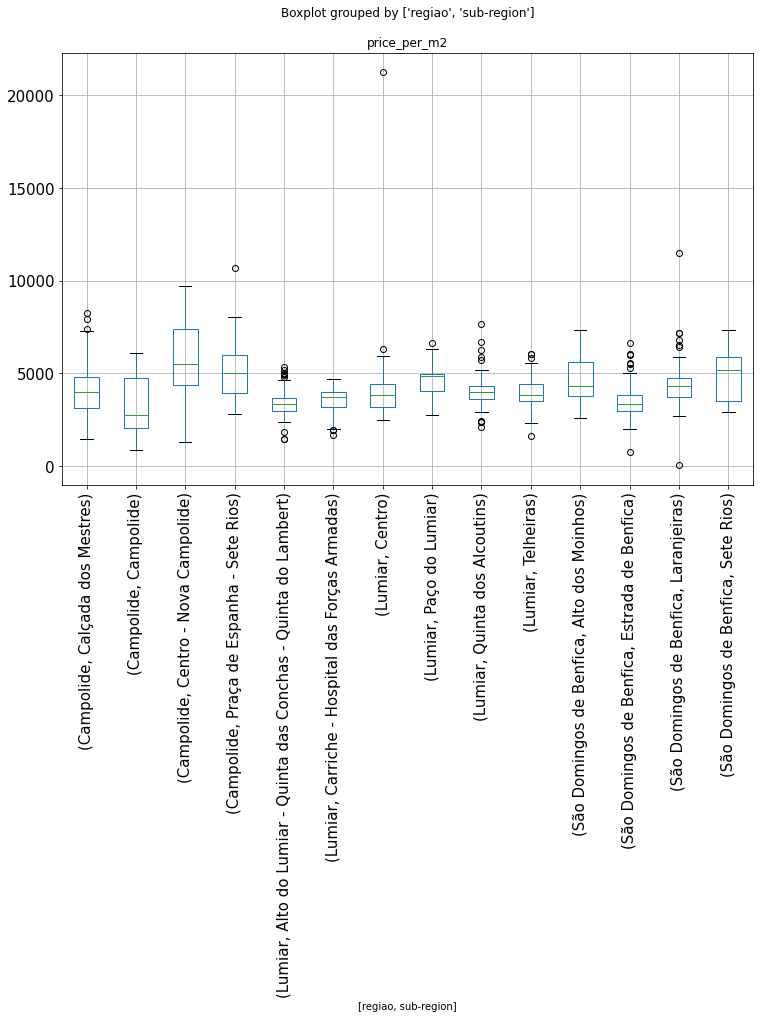

In [ ]:
molduraDeDados.boxplot(column=['price_per_m2'], by=['regiao','sub-region'], rot=90, fontsize=15, figsize=[12,8], )

### Digging into the outliers
```An outlier is an observation that lies an abnormal distance from other values in a random sample from a population.```
```Since we are working with real-world data, it is normal that some of the data extracted will come with errors or innacuracies, such as missing field or typos.```
```Looking further into some of the outliers seen in the last visualization, we can check that some of the fields are probably incorrect, hence the abnormal price per square meter. As you can see by checking the link, the apartment below is unlikely to be only 24 square meters.This is why visualizing can not only help you understand and share your data, but also identify potential problems and/or unclean data.```

In [ ]:
molduraDeDados[molduraDeDados['price_per_m2'] > 20000]

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region,price_per_m2,price_m2_per_subregion,price_ratio
723,31133617,Apartamento T4 na rua Ernesto Costa s/n Centro...,Lumiar,510000.0,T4,24.0,9999,idealista.pt/imovel/31133617/,234430129,4,Apartamento,Centro,21250.0,4179.56,5.08


### *Finding the ratio between area and rooms*

In [ ]:
molduraDeDados = molduraDeDados.astype({'rooms':int})

quartos = molduraDeDados[molduraDeDados['rooms'] > 0]


molduraDeDados['area/room'] = round(molduraDeDados.area/molduraDeDados.rooms, 2)
molduraDeDados = molduraDeDados.replace([np.inf, -np.inf], np.nan)


molduraDeDados.sort_values(by='area/room')

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region,price_per_m2,price_m2_per_subregion,price_ratio,area/room
723,31133617,Apartamento T4 na rua Ernesto Costa s/n Centro...,Lumiar,510000.0,T4,24.0,9999,idealista.pt/imovel/31133617/,234430129,4,Apartamento,Centro,21250.00,4179.56,5.08,6.00
1293,29460136,Moradia em Centro - Nova Campolide Campolide,Campolide,170000.0,T2,30.0,9999,idealista.pt/imovel/29460136/,215567264,2,Moradia,Centro - Nova Campolide,5666.67,5715.21,0.99,15.00
293,31372701,Apartamento T2 na rua Santa Matilde s/n Estrad...,São Domingos de Benfica,215000.0,T2,36.0,9999,idealista.pt/imovel/31372701/,215552796,2,Apartamento,Estrada de Benfica,5972.22,3510.87,1.70,18.00
336,31609570,Moradia geminada em Estrada de Benfica São Dom...,São Domingos de Benfica,250000.0,T3,56.0,9999,idealista.pt/imovel/31609570/,215550302,3,Moradia,Estrada de Benfica,4464.29,3510.87,1.27,18.67
1071,31624072,Apartamento T2 na rua General Taborda Centro -...,Campolide,180000.0,T2,40.0,3,idealista.pt/imovel/31624072/,215550306,2,Apartamento,Centro - Nova Campolide,4500.00,5715.21,0.79,20.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,31599465,Apartamento T0 em Centro - Nova Campolide Camp...,Campolide,575000.0,T0,111.0,9999,idealista.pt/imovel/31599465/,210020965,0,Apartamento,Centro - Nova Campolide,5180.18,5715.21,0.91,NaN
1182,31514737,Apartamento T0 em Centro - Nova Campolide Camp...,Campolide,350000.0,T0,45.0,2,idealista.pt/imovel/31514737/,215555697,0,Apartamento,Centro - Nova Campolide,7777.78,5715.21,1.36,NaN
1185,30914602,Apartamento T0 na avenida Conselheiro Fernando...,Campolide,350000.0,T0,45.0,9999,idealista.pt/imovel/30914602/,215554759,0,Apartamento,Centro - Nova Campolide,7777.78,5715.21,1.36,NaN
1264,31589283,Apartamento T0 em Praça de Espanha - Sete Rios...,Campolide,138000.0,T0,22.0,7,idealista.pt/imovel/31589283/,215560926,0,Apartamento,Praça de Espanha - Sete Rios,6272.73,5147.95,1.22,NaN


In [ ]:
quartos = molduraDeDados[molduraDeDados['rooms'] > 0]

quartos.sort_values(by='rooms')

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region,price_per_m2,price_m2_per_subregion,price_ratio,area/room
706,31519929,Apartamento T1 na rua Daciano Costa s/n Quinta...,Lumiar,340000.0,T1,116.0,9999,idealista.pt/imovel/31519929/,215559701,1,Apartamento,Quinta dos Alcoutins,2931.03,4089.96,0.72,116.00
943,31445704,Apartamento T1 na rua de Campolide s/n Praça d...,Campolide,420000.0,T1,66.0,6,idealista.pt/imovel/31445704/,215551563,1,Apartamento,Praça de Espanha - Sete Rios,6363.64,5147.95,1.24,66.00
1186,30914593,Apartamento T1 na avenida Conselheiro Fernando...,Campolide,510000.0,T1,67.0,9999,idealista.pt/imovel/30914593/,215554759,1,Apartamento,Centro - Nova Campolide,7611.94,5715.21,1.33,67.00
153,31600601,Apartamento T1 na estrada de Benfica s/n Estra...,São Domingos de Benfica,295000.0,T1,104.0,9999,idealista.pt/imovel/31600601/,215552796,1,Apartamento,Estrada de Benfica,2836.54,3510.87,0.81,104.00
154,30794557,Apartamento T1 em Laranjeiras São Domingos de ...,São Domingos de Benfica,250000.0,T1,50.0,9999,idealista.pt/imovel/30794557/,215562293,1,Apartamento,Laranjeiras,5000.00,4359.62,1.15,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,31644729,Apartamento T8 na avenida Columbano Bordalo Pi...,São Domingos de Benfica,780000.0,T8,270.0,3,idealista.pt/imovel/31644729/,926137653,8,Apartamento,Sete Rios,2888.89,4948.95,0.58,33.75
996,30787731,Moradia independente na rua 3 3 Bairro Calçada...,Campolide,950000.0,T9,650.0,9999,idealista.pt/imovel/30787731/,928154981,9,Moradia,Calçada dos Mestres,1461.54,4138.47,0.35,72.22
988,31298736,Moradia geminada em Centro - Nova Campolide Ca...,Campolide,4500000.0,T9,530.0,9999,idealista.pt/imovel/31298736/,215552748,9,Moradia,Centro - Nova Campolide,8490.57,5715.21,1.49,58.89
700,29588100,Herdade em Paço do Lumiar Lumiar,Lumiar,7500000.0,T9,1513.0,9999,idealista.pt/imovel/29588100/,215565264,9,NaN,Paço do Lumiar,4957.04,4682.32,1.06,168.11


### Creating a new table according to the investor preferences :

In [ ]:
molduraDeDadosFinal = molduraDeDados[
    (molduraDeDados.preco < 500000) &
    (molduraDeDados.rooms < 3) &
    (molduraDeDados.price_per_m2 < molduraDeDados.price_m2_per_subregion) &
    ((molduraDeDados.House_Type == 'Apartamento') | (molduraDeDados.House_Type == 'Duplex')) &
    (molduraDeDados.floor > 0)
]

molduraDeDadosFinal

,id,titulo,regiao,preco,typology,area,floor,link,contacto,rooms,House_Type,sub-region,price_per_m2,price_m2_per_subregion,price_ratio,area/room
1,31330543,Apartamento T1 em Sete Rios São Domingos de Be...,São Domingos de Benfica,278000.0,T1,68.0,4,idealista.pt/imovel/31330543/,215561507,1,Apartamento,Sete Rios,4088.24,4948.95,0.83,68.0
6,30844278,Apartamento T2 na avenida Columbano Bordalo Pi...,São Domingos de Benfica,350000.0,T2,80.0,9999,idealista.pt/imovel/30844278/,215557028,2,Apartamento,Sete Rios,4375.00,4948.95,0.88,40.0
7,31626666,Apartamento T2 em Laranjeiras São Domingos de ...,São Domingos de Benfica,365000.0,T2,95.0,2,idealista.pt/imovel/31626666/,215555638,2,Apartamento,Laranjeiras,3842.11,4359.62,0.88,47.5
11,31619949,Apartamento T2 em Estrada de Benfica São Domin...,São Domingos de Benfica,265000.0,T2,82.0,1,idealista.pt/imovel/31619949/,215555798,2,Apartamento,Estrada de Benfica,3231.71,3510.87,0.92,41.0
47,31568117,Apartamento T2 em Estrada de Benfica São Domin...,São Domingos de Benfica,287000.0,T2,86.0,3,idealista.pt/imovel/31568117/,215551936,2,Apartamento,Estrada de Benfica,3337.21,3510.87,0.95,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,31556027,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,400000.0,T2,80.0,2,idealista.pt/imovel/31556027/,215551894,2,Apartamento,Centro - Nova Campolide,5000.00,5715.21,0.87,40.0
1286,31270951,Apartamento T2 em Centro - Nova Campolide Camp...,Campolide,326500.0,T2,100.0,3,idealista.pt/imovel/31270951/,215569168,2,Apartamento,Centro - Nova Campolide,3265.00,5715.21,0.57,50.0
1291,31521195,Apartamento T2 em Praça de Espanha - Sete Rios...,Campolide,249000.0,T2,75.0,9999,idealista.pt/imovel/31521195/,0,2,Apartamento,Praça de Espanha - Sete Rios,3320.00,5147.95,0.64,37.5
1292,30401733,Apartamento T1 em Centro - Nova Campolide Camp...,Campolide,195000.0,T1,69.0,9999,idealista.pt/imovel/30401733/,215564386,1,Apartamento,Centro - Nova Campolide,2826.09,5715.21,0.49,69.0


#### *According to the investor's preference- as a reminder - apartments or duplex T0, T1 or T2, with a maximum price of 500.000€, a price per square meter below the sub-region average, above the ground floor (1st floor or higher)* 
#### *We found a total of 227 houses. 94 houses in Campolide , 96 in Lumiar and 37 in Benfica.*

In [ ]:
n_filtered_region = molduraDeDadosFinal.groupby('regiao')['sub-region'].count()

n_filtered_region

regiao
Campolide                  97
Lumiar                     94
São Domingos de Benfica    37
Name: sub-region, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

n_filtered_region = molduraDeDadosFinal.groupby('regiao')['preco'].count()

#fig, ax = plt.subplots()

#ax.set_title('Total houses filtered per region')
#ax.set_label('')
#ax.pie(n_filtered_region, labels=('Lumiar','Benfica','Campolide'))
#fig.savefig('Houses_per_region.png')

graph = n_filtered_region.plot.pie(figsize=(10,10))
graph.set_title('Total houses filtered per region', fontdict={'fontsize':16,'fontweight':'bold'})
graph.set_ylabel('')
plt.savefig('Houses_filtered_region.png')
plt.close()


### *We can also see by looking at the data. The total amount of houses filtered all correspond to the same type : apartment.*

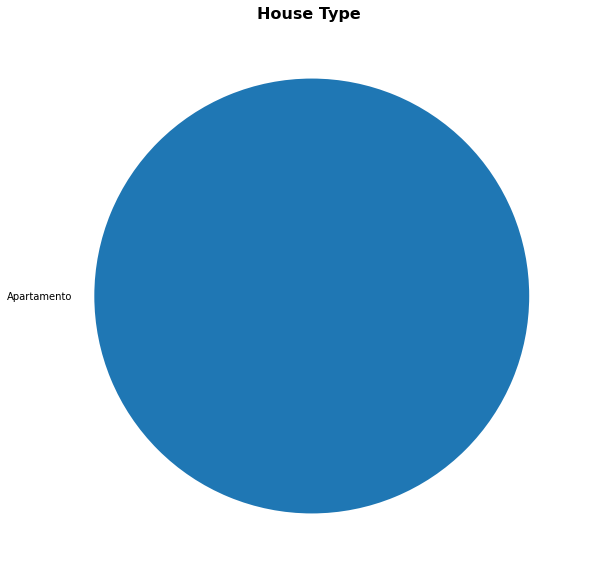

In [ ]:
n_HouseType = molduraDeDadosFinal.groupby('House_Type')['House_Type'].count()

houseTypeGraph = n_HouseType.plot.pie(figsize=(10,10))
houseTypeGraph.set_ylabel('')
houseTypeGraph.set_title('House Type ', fontdict={'fontsize':16,'fontweight':'bold'})
plt.savefig('Houses_type.png')

### *We can check the difference in price between the filtered houses by sub-region.*

In [ ]:
price_by_sub = molduraDeDadosFinal.groupby(by='sub-region')['price_per_m2'].mean()

grafico1 = price_by_sub.plot.bar(figsize=(10,10)).set_title('Price per m2 by sub-region on filtered houses', fontdict={'fontsize':16, 'fontweight':'bold'})

grafico1
plt.savefig('price_m2_subregion.png')
plt.close()

### The different type of house typology for the total number of houses filtered 

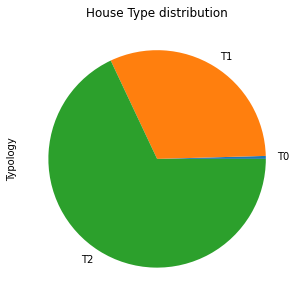

In [ ]:
typology_group_count = molduraDeDadosFinal.groupby('typology')['typology'].count()

#pieGraph = typology_group_count.plot.pie(figsize=(10,10)).set_title('House type distribution')

fig , ax = plt.subplots()

fig.set_size_inches(5,5)
ax.set_title('House Type distribution')
ax.pie(typology_group_count, labels=['T0','T1','T2'])
ax.set_ylabel('Typology')
fig.savefig('House Type distribution')




# ***5)Share - The results***

### *Writing the filtered data to an excel file.*

``` We can take the dataframe and write it to an excel file to share with others or allow for different data manipulation. ```

In [ ]:
molduraDeDadosFinal.to_excel('Investor_Preferences.xlsx',sheet_name='Investor_Preferences')

### *Creating a function to generate graphs based on the data given*

In [ ]:
def plot(data: pd.DataFrame, filename: str) -> None:
    plt.figure(figsize=(12, 4))
    plt.grid(color='#F2F2F2', alpha=1, zorder=0)
    plt.pie(data['Date'], data['ItemsSold'], color='#087E8B', lw=3, zorder=5)
    plt.title(f'Report/{data["Date"].dt.month[0]}', fontsize=17)
    plt.xlabel('Period', fontsize=13)
    plt.xticks(fontsize=9)
    plt.ylabel('Number of items sold', fontsize=13)
    plt.yticks(fontsize=9)
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()
    return

### *Creating a PDF file to showcase the analysis as a report*


```Installing FPDF :```

In [ ]:
pip install fpdf2

```Preparing the PDF file : ```

In [ ]:
from fpdf import FPDF

#we will inherit from the FPDF class and create a new class, extending the header method
class PDF(FPDF):
  def header(self):
    #logo
    #x position on the page
    #y position on the page
    # size of the image
    #self.image('ChildBros_Logo.png',10,12,25)
    #font
    self.set_font('helvetica', 'BUI', 20)
    #Title
    self.cell(0,25,'Simple report on collected data', border=True, ln=True, align='C')
    #Line break
    self.ln(20)

#Now we can use the class we created and instance it.
#Layout ('P', 'L')
#Unit ('mm','cm','inch')
#format('A3','A4' (default),'A5','Letter', 'Legal', custom -> '(w,h)' )
pdf = PDF('P','mm','Letter')

#Setting auto page break. So that it starts a new page, if we want to keep writing after no more space in the page is left.
# margin sets how far from the bottom of the page we are going to break to next page.
pdf.set_auto_page_break(auto=True, margin = 15)

#Add a page
pdf.add_page()

#Specify font
# fonts('times','courier','helvetica','symbol','zpfdingbats')
# 'B'(bold) , 'U' , (underline), 'I' (italics), '' (regular)
pdf.set_font('helvetica', '' , 14)

# Add text
# width of the cell = w
# height of the cell = h
# txt = The text you want to write.
# ln = true is telling the cursor to move down to the next line after this one is complete.
# border -> Adds a border arround our cell like in CSS
pdf.cell(40,15,'Overview' , ln=True , border = False, align='C', center=True)
pdf.set_font('helvetica', '' , 10)
pdf.multi_cell(0,5,'This is a visual representation for the attached excell file, which displays an overview of the data. This data was extracted from the real-estate website idealista and is filtered according to the investor preferences.')
pdf.image('/content/Houses_filtered_region.png', w=75, h=75,x= (pdf.w-75)/2)
pdf.image('price_m2_subregion.png', w=75, h=70, x= (pdf.w-75)/2)
pdf.image('Houses_type.png', w=75, h=70, x= (pdf.w-75)/2)
pdf.image('House Type distribution.png', w=75, h=70, x= (pdf.w-75)/2)

pdf.output('Weekly_Report.pdf')

### *Building a server to send e-mail automaticallly*

In [ ]:
pip install yagmail

     |████████████████████████████████| 404 kB 40.4 MB/s 


In [ ]:
import smtplib
import yagmail
from email import message
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.application import MIMEApplication
from email import encoders
from os.path import basename

sender_email = 'testmilesinthesky@gmail.com'
rec_email = 'smmbonvalot@gmail.com' #change to your e-mail
password = '$a123456'
titulo = 'Automated Report'

content = ['This e-mail was automatically sent with the latest automated analysis on the website idealista.','Investor_Preferences.xlsx', 'Weekly_Report.pdf']

with yagmail.SMTP(sender_email, password) as yag:
    yag.send(rec_email, titulo, content)
    print('Sent email successfully')

#------------------------------------------------------------>DISREGARD COMMENTS BELOW<-----------------------#

#msg = MIMEMultipart()
#msg['From'] = sender_email
#msg['To'] = rec_email
#msg['Subject'] = titulo
#content = MIMEText(body,'plain')
#msg.attach(content)

#attach_file_name = 'Automated_Report.pdf'
#attach_file = open('Weekly_Report.pdf', 'rb') # Open the file as binary mode
#payload = MIMEBase('application', 'octate-stream')
#payload.set_payload(attach_file.read())
#encoders.encode_base64(payload) #encode the attachment
#add payload header with filename
#payload.add_header('Content-Decomposition', 'attachment', filename=attach_file_name)
#msg.attach(payload)

#msg= message.Message()
#msg.add_header('from', sender_email)
#msg.add_header('to', rec_email)
#msg.add_header('subject', titulo)
#msg.set_payload('payload', body)



#server = smtplib.SMTP('smtp.gmail.com', 587)
#server.starttls()
#server.login(sender_email, password)
#print('Login sucess!')
#text = msg.as_string()
#server.sendmail(sender_email , rec_email , msg.as_string())
#print('Email has been sent to : ' + rec_email)

Sent email successfully
